In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Loading data

In [2]:
train_data = pd.read_csv('train.csv', index_col=0)

train_data.info()

train_data.head()

train_data.describe()

train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 51.5+ MB


Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [3]:
test_data = pd.read_csv('test.csv')

test_data.info()

test_data.head()

test_data.describe()

test_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

# Exploratory Data Analysis

## Categorical Feature

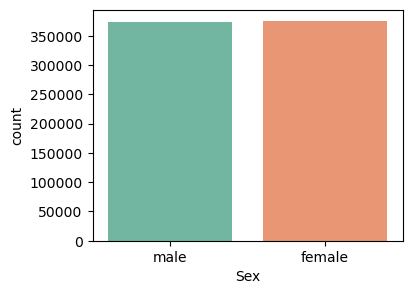

In [4]:
cat_cols = [col for col in train_data.columns if train_data[col].dtype=='O']
categorical = train_data[cat_cols]
train_data["Sex"].value_counts()
plt.figure(figsize=(4,3))
sns.countplot(x='Sex', data=train_data, palette = "Set2", hue='Sex', legend=False)
plt.show()

## Numerical Features

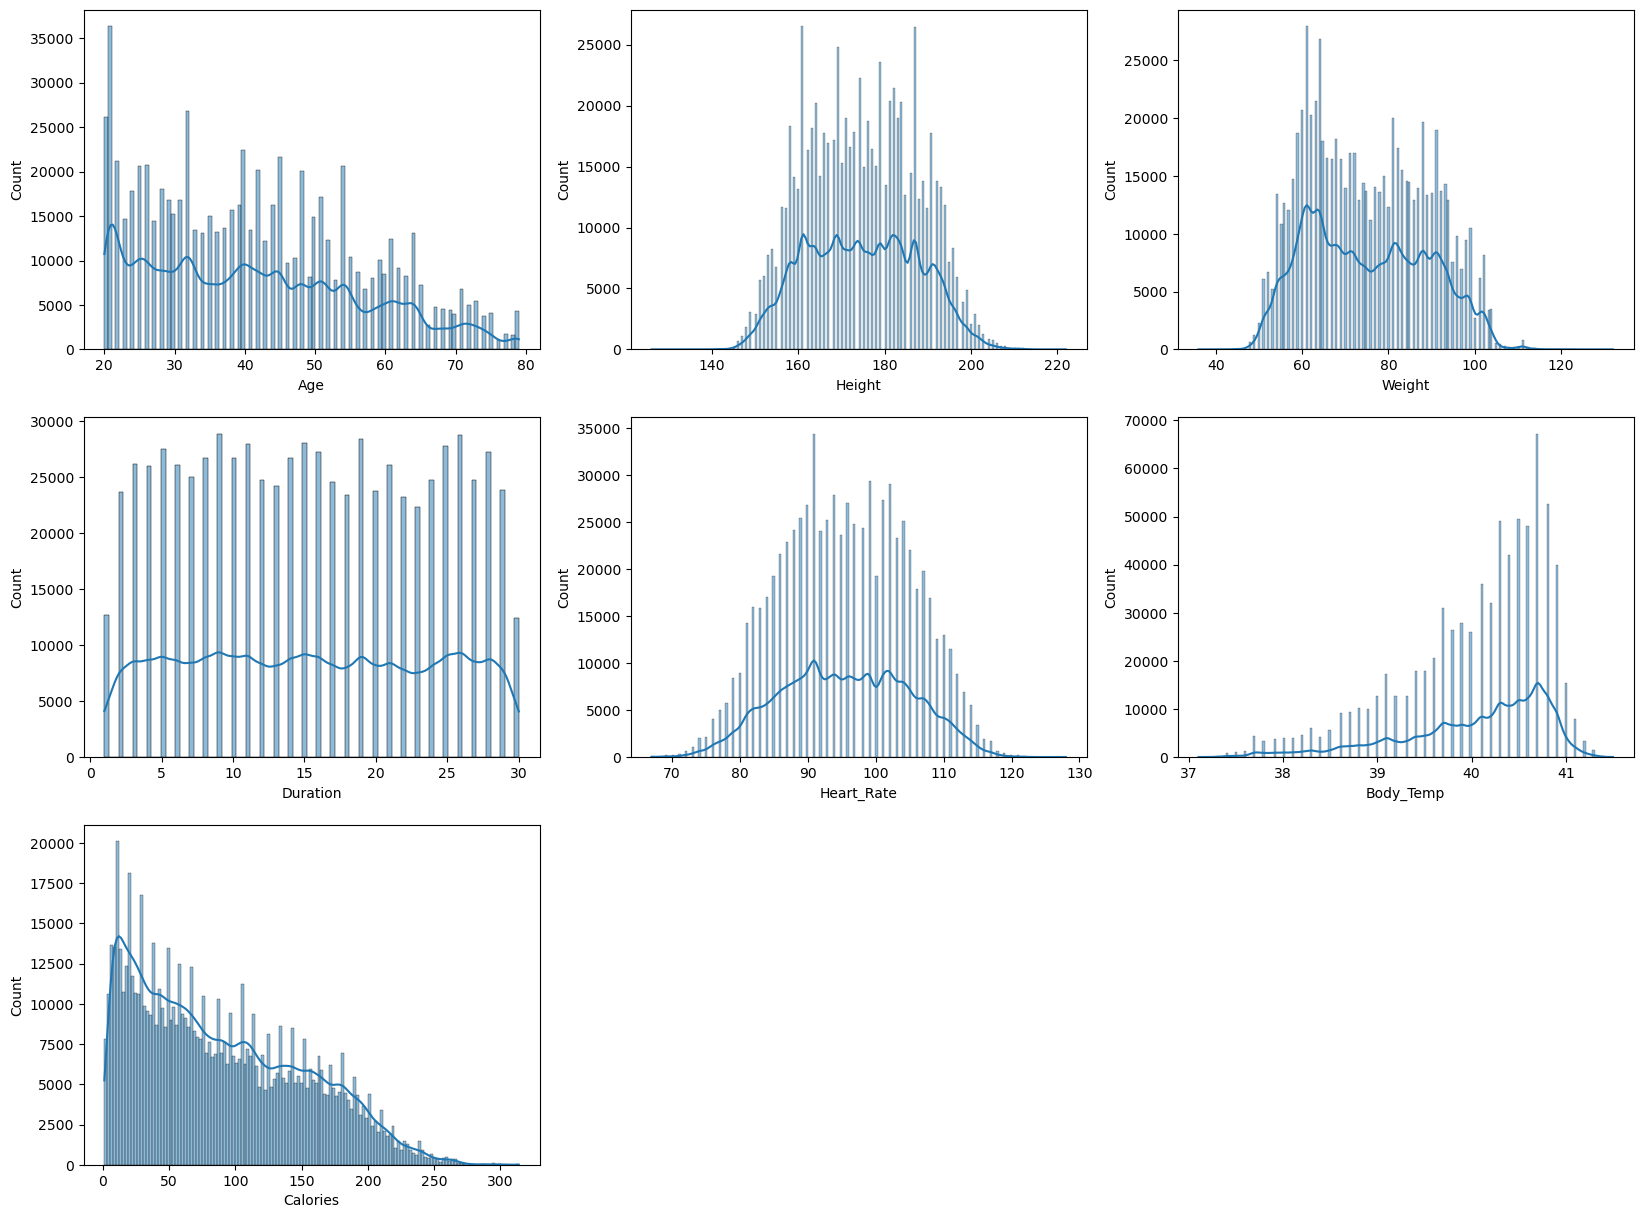

In [5]:
num_cols = [col for col in train_data.columns if train_data[col].dtype != 'O']
numerical = train_data[num_cols]
plt.figure(figsize=(20,15))
plot_num = 1
for column in numerical:
    if plot_num <= 8:
        ax = plt.subplot(3,3, plot_num)
        sns.histplot(numerical[column], kde=True)
        plt.xlabel(column, fontsize=10)
    plot_num +=1
plt.show()

<Axes: >

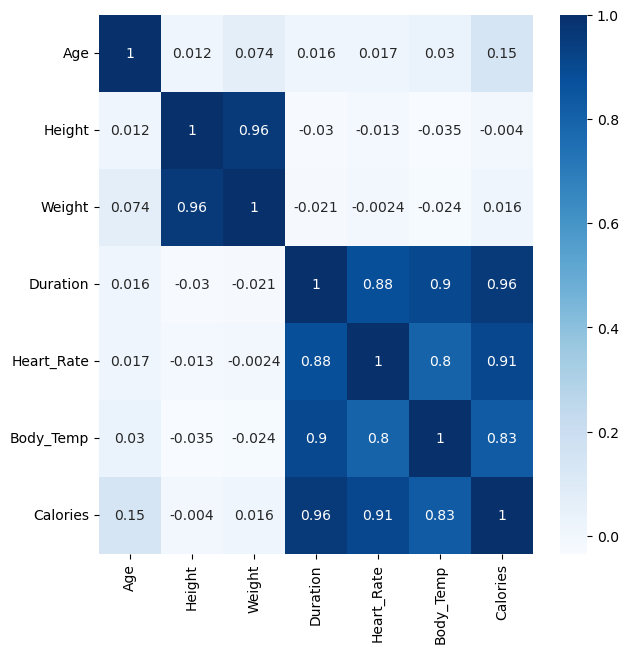

In [6]:
plt.figure(figsize=(7,7))
sns.heatmap(numerical.corr(), cmap='Blues', annot=True)

<Axes: >

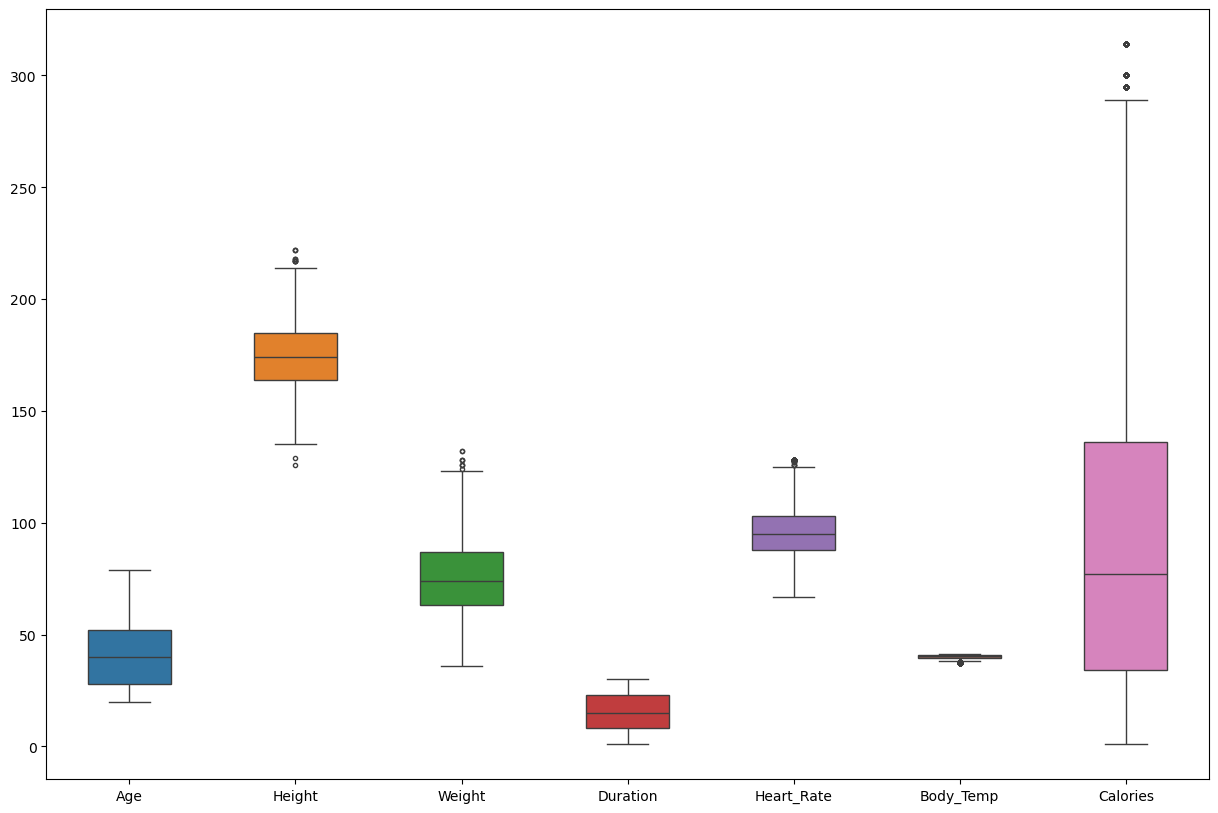

In [7]:
data = pd.concat([categorical,numerical],axis=1)
fig,ax = plt.subplots(figsize = (15,10))
sns.boxplot(data=data,width = 0.5,fliersize = 3,ax=ax)

# Feature Engineering

In [8]:
# Add BMI and intensity
train_data['BMI'] = train_data['Weight'] / (train_data['Height'] / 100) ** 2
train_data['Intensity'] = train_data['Heart_Rate'] / train_data['Duration']

test_data['BMI'] = test_data['Weight'] / (test_data['Height'] / 100) ** 2
test_data['Intensity'] = test_data['Heart_Rate'] / test_data['Duration']

numeric_cols = ['Age', 'Weight', 'Height', 'Body_Temp', 'Heart_Rate', 'Duration', 'Sex', 'AgeSex']
def feature_engineering(df, numeric_cols):
    df['Sex'] = df['Sex'].map({'female': 1, 'male': 2})
    df['AgeSex'] = df['Age'].astype(str) + df['Sex'].astype(str)
    df['AgeSex'] = LabelEncoder().fit_transform(df['AgeSex']) + 1
    for i in range(len(numeric_cols)):

        feature_1 = numeric_cols[i]
        for j in range(i+1,len(numeric_cols)):
            feature_2 = numeric_cols[j]
            df[f'{feature_1}_x_{feature_2}'] = df[feature_1] * df[feature_2]
           
    return df

train_data = feature_engineering(train_data, numeric_cols)
test_data = feature_engineering(test_data, numeric_cols)
train_data['Sex'] = train_data['Sex'].astype('category')
test_data['Sex'] = test_data['Sex'].astype('category')
train_data['Duration_cat'] = pd.cut(train_data['Duration'],bins = 10 , labels=False, right=False)
test_data['Duration_cat'] = pd.cut(test_data['Duration'],bins = 10 , labels=False, right=False)

In [11]:
X = train_data.drop(columns=['Calories'], axis=1)
y = np.log1p(train_data["Calories"])

In [12]:
x_test = test_data.drop(columns=['id'], axis=1)

# Model Building

In [13]:
FOLDS = 20 #10
KF = KFold(n_splits=FOLDS, shuffle = True, random_state = 42)
cat_features = ['Sex']
oof_cat = np.zeros(len(train_data))
pred_cat = np.zeros(len(test_data))
oof_xgb = np.zeros(len(train_data))
pred_xgb = np.zeros(len(test_data))
oof_lgb = np.zeros(len(train_data))
pred_lgb = np.zeros(len(test_data))

# CATBOOST MODEL
cat_model = CatBoostRegressor(
    iterations= 2000, #3500
    learning_rate= 0.02,
    depth= 12,
    loss_function= 'RMSE',
    l2_leaf_reg= 3,
    random_seed= 42,
    eval_metric= 'RMSE',
    early_stopping_rounds = 200,
    verbose= 1000,
    task_type= 'GPU')

## XGBOOST
xgb_model = XGBRegressor(
    max_depth=10,
    colsample_bytree=0.75,
    subsample=0.9,
    n_estimators=2000,
    learning_rate=0.01,
    gamma=0.01,
    max_delta_step=2,
    early_stopping_rounds=100,
    eval_metric="rmse",
    random_state = 13,
    enable_categorical=True,
    device = 'cuda')

lgb_model  = LGBMRegressor(
    objective= "regression",
    metric= "rmse",
    learning_rate=0.02,
    n_estimators= 3000, 
    num_leaves= 128,  
    max_depth= 10, 
    min_child_samples= 20, 
    min_split_gain= 0.01,
    subsample= 0.8,
    colsample_bytree= 0.8,
    early_stopping_rounds=100,
    reg_alpha= 3.0, 
    reg_lambda= 1.0,
    random_state= 42,
    verbosity= -1,
    feature_fraction= 0.7,
    force_col_wise=True
)


In [14]:
from sklearn.metrics import mean_squared_error

for i, (train_idx,valid_idx) in enumerate(KF.split(X,y)):
    print('#' * 15, i+1, '#' *15)
    ## SPLIT DS 
    X_train,y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]
 
    ## CATBOOST fit
    cat_model.fit(X_train, y_train, eval_set=[(X_valid,y_valid)],cat_features=cat_features,
            use_best_model=True,verbose=0)
    ## XGB FIR
    xgb_model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],verbose=0)
    ## LGB MODEL
    lgb_model.fit(X_train,y_train,eval_set=[(X_valid, y_valid)])
    ## PREDICTION CATBOOST
    oof_cat[valid_idx] = cat_model.predict(X_valid)
    pred_cat += cat_model.predict(x_test)
    ## PREDICTION XGB
    oof_xgb[valid_idx] = xgb_model.predict(X_valid)
    pred_xgb += xgb_model.predict(x_test)
    ## PREDICTION LGB
    oof_lgb[valid_idx] = lgb_model.predict(X_valid)
    pred_lgb += lgb_model.predict(x_test)
    
    cat_rmse = mean_squared_error(y_valid, oof_cat[valid_idx]) ** 0.5
    xgb_rmse = mean_squared_error(y_valid, oof_xgb[valid_idx]) ** 0.5
    lgb_rmse = mean_squared_error(y_valid, oof_lgb[valid_idx]) ** 0.5
    
    print(f'FOLD {i+1} CATBOOST_RMSE = {cat_rmse:.4f} <=> XGB_RMSE = {xgb_rmse:.4f} <=> LGB_RMSE = {lgb_rmse:.4f}')

############### 1 ###############


C:\Users\Cs-Store\anaconda3\Lib\site-packages\xgboost\core.py:729: UserWarning: [08:30:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


FOLD 1 CATBOOST_RMSE = 0.0608 <=> XGB_RMSE = 0.0619 <=> LGB_RMSE = 0.0611
############### 2 ###############
FOLD 2 CATBOOST_RMSE = 0.0590 <=> XGB_RMSE = 0.0589 <=> LGB_RMSE = 0.0594
############### 3 ###############
FOLD 3 CATBOOST_RMSE = 0.0591 <=> XGB_RMSE = 0.0590 <=> LGB_RMSE = 0.0598
############### 4 ###############
FOLD 4 CATBOOST_RMSE = 0.0585 <=> XGB_RMSE = 0.0587 <=> LGB_RMSE = 0.0585
############### 5 ###############
FOLD 5 CATBOOST_RMSE = 0.0618 <=> XGB_RMSE = 0.0627 <=> LGB_RMSE = 0.0619
############### 6 ###############
FOLD 6 CATBOOST_RMSE = 0.0608 <=> XGB_RMSE = 0.0613 <=> LGB_RMSE = 0.0611
############### 7 ###############
FOLD 7 CATBOOST_RMSE = 0.0596 <=> XGB_RMSE = 0.0598 <=> LGB_RMSE = 0.0610
############### 8 ###############
FOLD 8 CATBOOST_RMSE = 0.0575 <=> XGB_RMSE = 0.0579 <=> LGB_RMSE = 0.0578
############### 9 ###############
FOLD 9 CATBOOST_RMSE = 0.0594 <=> XGB_RMSE = 0.0602 <=> LGB_RMSE = 0.0597
############### 10 ###############
FOLD 10 CATBOOST_RMSE = 0.0

In [15]:
pred_cat /= FOLDS
pred_xgb /= FOLDS
pred_lgb /= FOLDS

In [16]:
y_preds = np.expm1(pred_cat) * 0.30 + np.expm1(pred_xgb)*0.60 + np.expm1(pred_lgb)*0.1
y_preds = np.clip(y_preds, 1, 314)

# Submission

In [ ]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'Calories': y_preds
})

submission.to_csv('sub_ensemble_25_25_50.csv', index=False)